In [1]:
import datetime
import platform
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from scipy import stats
import sklearn.metrics as m
import statsmodels.api as sm
from fbprophet import Prophet
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from sklearn.ensemble import VotingClassifier, RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
from warnings import filterwarnings
filterwarnings('ignore')

### Mini project 개요

- Step0 : 전처리 과정 및 기계학습을 이용한 예측을 위해 각 자료로부터 Feature을 만들어 줌.<br><br>

- Step1 : 추가 데이터 자료로부터 워드 클라우드 등을 이용한 시각화 위주의 데이터 분석을 진행.<br><br>

- Step2 : Arima 모형을 이용한 시계열 분석 ==> 예측 기간이 길어지면 잘 예측되지 않은 형태가 보임. ==> 모델 선정시 더 많은 경우를 고려할 필요가 있어보임.<br><br>

- Step3 : 기계 학습을 통한 모형 예측을 위해 데이터의 정규화 => 정상적 시계열 데이터를 만들어주기 위해 Box-cox, 차분, log 변환 등을 이용하려고 했으며 Knn을 제외한 예측기로부터 잘 학습되는 양상을 보였음.<br><br>

- Step4 : 만든 특성데이터간의 상관관계를 살피고, 얼마나 유의미한지를 판단하며, VIF값을 통해 다중공선성을 살펴보고 해결.<br><br>

- Step5 : 기계학습을 이용한 다양한 모델을 그리드 서치 함수를 통과 시켜 정확도를 파악. 최종 모델로 lasso를 적용시킴. <br><br>

- 참조  : 추가적으로 페이스북에서 만든 모형( fbprophet )를 이용한 180일 이후 추세선 예측하여 봄.<br><br>

### Step0.  데이터 핸들링 

In [2]:
# < 데이터 >
data1 = pd.read_csv("open_data/1차_open_data/train.csv", encoding = 'euc-kr', 
                    parse_dates=['DateTime'], index_col='DateTime')

data2 = pd.read_csv("open_data/2차_open_data/2차_train.csv", encoding = 'euc-kr', 
                    parse_dates=['DateTime'], index_col='DateTime')

# < 추가 데이터 >
# ----------------------------------------------------------------------------------------------

# submission2와 중복.
# submission1  = pd.read_csv('open_data/1차_추가데이터/info_submission.csv', encoding = 'euc-kr', 
#                            index_col='Unnamed: 0')
submission2  = pd.read_csv('open_data/2차_추가데이터/new_submission_info.csv', encoding = 'euc-kr', 
                           index_col='Unnamed: 0', parse_dates=['c_time'])


# ----------------------------------------------------------------------------------------------

# login2와 중복.
login1       = pd.read_csv('open_data/1차_추가데이터/info_login.csv', encoding = 'euc-kr', 
                          index_col='Unnamed: 0')

login2       = pd.read_csv('open_data/2차_추가데이터/new_login_info.csv', encoding = 'euc-kr', 
                           index_col='Unnamed: 0', parse_dates=['c_time'])

# ----------------------------------------------------------------------------------------------

# user2와 중복.
# user1        = pd.read_csv('open_data/1차_추가데이터/info_user.csv', encoding = 'euc-kr', 
#                            index_col='Unnamed: 0')
user2        = pd.read_csv('open_data/2차_추가데이터/new_user_info.csv', encoding = 'euc-kr', 
                           index_col='Unnamed: 0', parse_dates=['c_time'])

# ----------------------------------------------------------------------------------------------

competition1 = pd.read_csv('open_data/1차_추가데이터/info_competition.csv', encoding = 'euc-kr', 
                            parse_dates=['period_start','period_end'], index_col='Unnamed: 0')

competition2 = pd.read_csv('open_data/2차_추가데이터/new_competition_info.csv', encoding = 'euc-kr', 
                            parse_dates=['period_start','period_end'], index_col='Unnamed: 0')


# < 데이터 전처리 및 특성데이터 만들기. >
# ----------------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------
# data analysis part

# 데이터 병합(competition 1차 추가 데이터가 2차 데이터에 있기 때문에 right join).
comp = pd.merge( competition1, competition2, on=['cpt_id', 'is_official', 'period_start', 'period_end', 
                'name', 'name_eng', 'keyword', 'keyword_eng', 'participants', 'max_team_member',
                'max_file_per_day', 'prize', 'prize_info', 'merge_deadline','winner_show'], how='right')

# 결측치 확인.
comp.isna().sum() 


# 맨 마지막 all 결측치 제거.
comp.dropna(axis=0, how='all', inplace=True )


# 테스트용 대회 제거 .
comp.drop( index=comp[ comp['keyword'].isnull() ].index , inplace=True )

# 키워드 텍스트
com_keyword = []
com_category = []


for i in comp['keyword'].values:
#     print(i)
#     print(str(i).replace('|',''))
    com_category.append(str(i).split('|')[:5])
    com_keyword.append(str(i).replace('|',''))

    
# 리스트를 텍스트로 변형
keyword_str = " ".join(com_keyword)


# 대회이름 분류
com_name = []
for i in comp['name'].values:
    com_name.append(i)
com_name
com_name_str = " ".join(com_name)


# 카테고리 분류
category = []
# for i in com_category:
for i in com_category:
    if '월간' in  i[0].strip():
        category.append( i[1].strip() )
    elif '프렌즈' in i[0].strip():
        category.append( i[1].strip() )
    elif 'LG' in i[0].strip():
        category.append( i[2].strip() )
    elif 'KT' in i[0].strip():
        category.append( i[2].strip() )
    elif 'Bflysoft' in i[0].strip():
        category.append( i[1].strip() )
    elif '국토' in i[0].strip():
        category.append( i[3].strip() )
    elif '한국수력원자력' in i[0].strip():
        category.append( i[1].strip() )
    elif '서울대' in i[0].strip():
        category.append( i[1].strip() )
    else:
        category.append( i[0].strip() )
category_str = " ".join(category)
# category_str


## ----------------------------------------------------------------------------------------------
# model part

train = pd.concat([ data1, data2 ])
Train = train.resample('D').sum()
Train_index = pd.DataFrame(Train.index)

# 하루 데이터 제출 수.
submission2.dropna( how='all', inplace=True )
submission2.set_index('c_time', inplace=True)
sub = submission2.resample('D').count()[['sub_id']]
sub = sub['2018-09-09':'2020-12-08']
sub.columns = ['Sub_count']


# 하루 신규 가입자 수.
user2.dropna( how='all', inplace=True )
user2.set_index( 'c_time', inplace=True )
user = user2.resample('D').count()[['id']]
user = user['2018-09-09':'2020-12-08']
user.columns = ['Register_count']


# 하루 로그인 수.
login2["c_time"].isna().sum()
login2.dropna(axis=0, how='all', inplace=True )
login2.set_index('c_time', inplace=True)
login = login2.resample('D').count()[['login_id']]
login = login['2018-09-09':'2020-12-08']
login.columns = ['login_count']


# 데이터 결합
Train = pd.concat([Train, user, sub, login ], axis=1)


# 기간별 없는 결측치 중앙값으로 대체하기.
Train.fillna(round(login.median()), inplace=True)


# 기간내 진행중인 대회 수 계산.
Train['comp_count']= 0
for start, end in zip(comp.period_start, comp.period_end):
    count =  Train[start:end]['comp_count']
    count += 1
    Train[start:end]['comp_count'] = count


# index datetime 설정 해제.    
Train.reset_index(drop = True, inplace=True)


# # 월:0 , 화:1 ,,,,,,, 일 : 6 요일별 범주화.
Train['Week']  = Train_index['DateTime'].dt.weekday  
Train = pd.concat([ Train_index, Train ], axis=1)

# DataFrame 확인.
Train

DateTime   사용자    세션  신규방문자   페이지뷰  Register_count  Sub_count  \
0   2018-09-09   281   266     73   1826               9         71   
1   2018-09-10   264   247     51   2092               4         74   
2   2018-09-11   329   310     58   1998               6         94   
3   2018-09-12   300   287     45   2595               2         93   
4   2018-09-13   378   344     50   3845               7         94   
..         ...   ...   ...    ...    ...             ...        ...   
817 2020-12-04  3189  3068    743  75730              42        352   
818 2020-12-05  2055  2019    497  47638              31        197   
819 2020-12-06  2119  2077    460  46914              24        192   
820 2020-12-07  2979  2988    753  77443              70        236   
821 2020-12-08  3033  2990    772  68857              70        223   

     login_count  comp_count  Week  
0          154.0           1     6  
1          154.0           1     0  
2          154.0           1     1  
3          154.0           1     2  
4          154.0           1     3  
..           ...         ...   ...  
817        276.0           6     4  
818        143.0           5     5  
819        169.0           5     6  
820        345.0           5     0  
821        299.0           5     1  

[822 rows x 10 columns]

### Step1. 데이터 분석 

#### [분야] 빈도분석 시각화  ==>   금융, 산업, 스포츠 부문의 대회 多

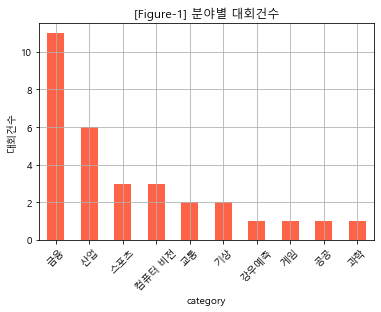

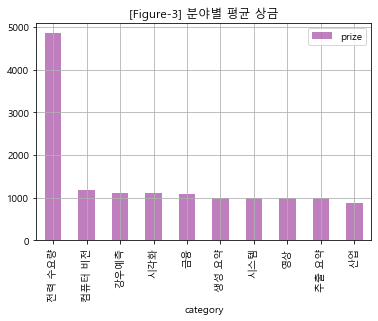

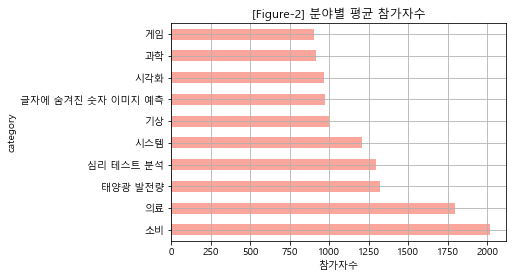

In [3]:
mg_com_copy = comp[['name','participants','prize']]
mg_com_copy['category'] = category
pivot_com = mg_com_copy.pivot_table( index='category', aggfunc=['mean','count'])
# mg_com_copy.groupby( 'category' ).mean().nlargest( 20, 'participants')

# 분야별 대회건수
pivot_com['count','name'].nlargest(10).plot(kind='bar', rot=45, color='tomato')
plt.title('[Figure-1] 분야별 대회건수')
plt.ylabel('대회건수')
plt.grid()
plt.show()

# 분야별 상금
mg_com_copy.groupby('category').mean()[['prize']].nlargest(10, 'prize').plot(kind='bar', color='purple', alpha=0.5)
plt.title('[Figure-3] 분야별 평균 상금')
plt.grid()
plt.show()## Q. 분야별 참가자수

# 분야별 참가자수
pivot_com['mean','participants'].nlargest(10).plot( kind='barh', color='salmon', alpha=0.7 )
plt.title('[Figure-2] 분야별 평균 참가자수')
plt.xlabel('참가자수')
plt.grid()
plt.show()

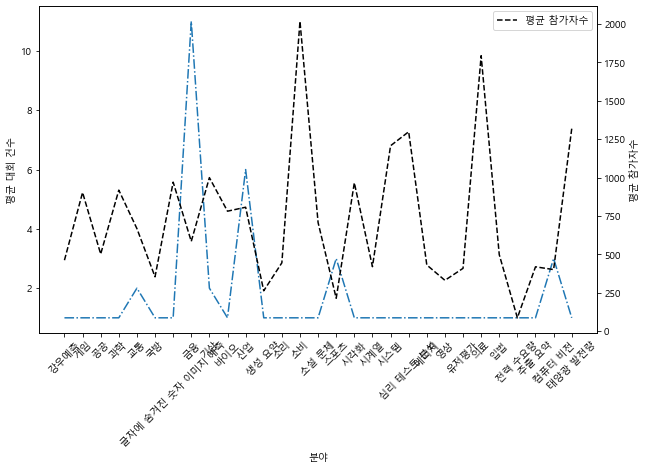

In [4]:
fig, ax1 = plt.subplots( figsize=(10,6) )

ax1.plot( pivot_com['count','name'], '-.')
ax1.set_xlabel('분야')
ax1.set_ylabel('평균 대회 건수')
plt.xticks( rotation=45 )


# y축을 오른쪽으로 잡아줌, y2를 그래프로 그릴 때 y2값은 오른쪽, y1값은 왼쪽
ax2 = ax1.twinx() 
ax2.plot( pivot_com['mean','participants'] ,'k--')
ax2.set_ylabel('평균 참가자수', color='black')
plt.xticks( rotation=45 )
plt.legend( ['평균 참가자수'] )
plt.show()

Windows


(-0.5, 799.5, 399.5, -0.5)

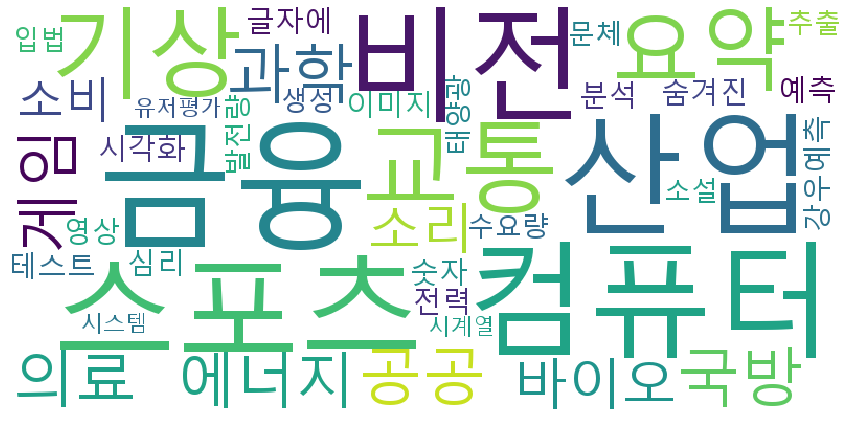

In [5]:
print(platform.system())
if platform.system() == 'Windows':  
    font_path = "c:/Windows/Fonts/malgun.ttf"
else:
    pass

from wordcloud import WordCloud, STOPWORDS

spwords=set(STOPWORDS)
spwords.add('nan')

wordcloud = WordCloud(font_path = font_path,
                     stopwords=spwords,                   
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(category_str)

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

#### [keyword] 빈도분석 시각화

(-0.5, 799.5, 399.5, -0.5)

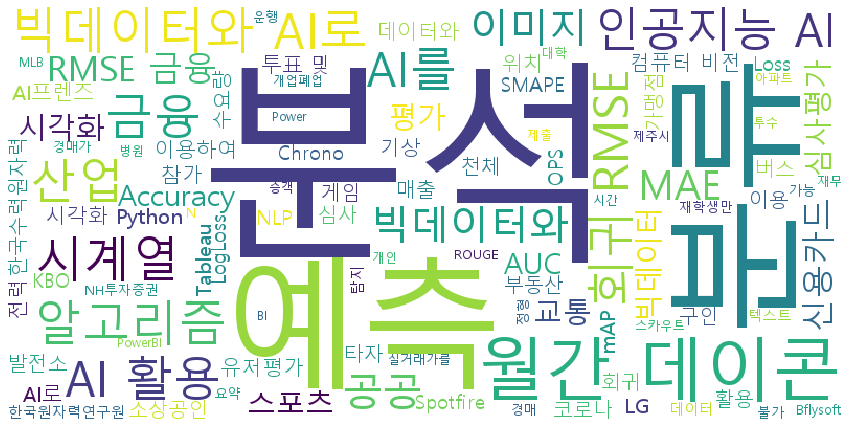

In [6]:
spwords=set(STOPWORDS)
wordcloud = WordCloud(font_path = font_path,
                     stopwords=spwords,                   
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   #최소 0부터 최대 1까지 값
                     width=800,
                     height=400
                     ).generate(keyword_str)

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

#### [대회명] 빈도분석 시각화

(-0.5, 799.5, 399.5, -0.5)

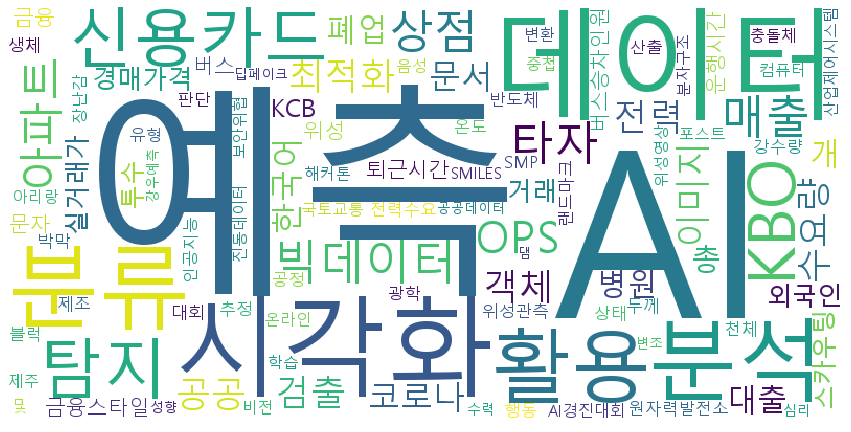

In [7]:
spwords=set(STOPWORDS)
spwords.add('경진대회')

wordcloud = WordCloud(font_path = font_path,
                     stopwords=spwords,                   
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   #최소 0부터 최대 1까지 값
                     width=800,
                     height=400
                     ).generate(com_name_str)

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

#### 상금이 많을 수록 사람들이 많이 참가하는가?   ==> 상금과 참가 인원 수 사이에는 상관관계가 없다고 판단됨.

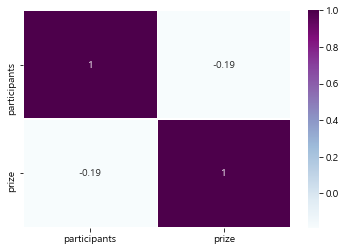

In [8]:
sb.heatmap( comp[['participants','prize']].corr(),annot=True, linewidths=0.2, cmap='BuPu')
plt.show()

#### 사람들은 PC, Mobile 중에 어떤 것을 가장 많이 쓸까?

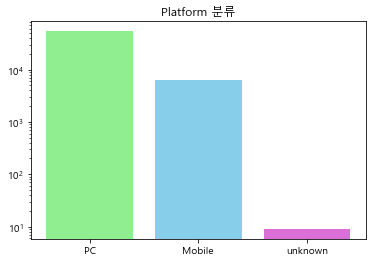

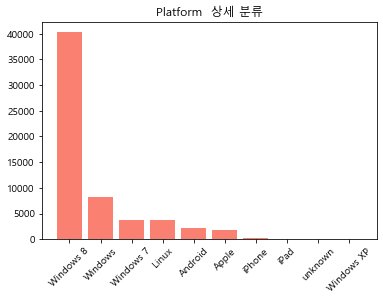

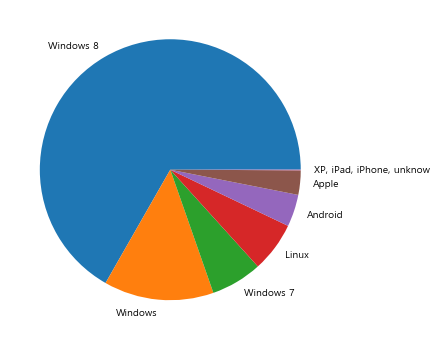

In [9]:
login3 = pd.merge(login1, login2, how='outer')
login3.dropna(inplace=True)
origin = login3[['platform']]
login3['platform'].replace( login3['platform'].unique(), [1,1,1,1,0,1,0,0,2,1] ,inplace=True) # 모바일 or 컴퓨터
plt.bar(['PC', 'Mobile', 'unknown'], login3['platform'].value_counts(), color=['lightgreen','skyblue','orchid'], log=True )
plt.title('Platform 분류')
plt.grid()
plt.show()

plt.bar( origin['platform'].unique()  , origin['platform'].value_counts(), color='salmon' )
plt.xticks(rotation=45)
plt.title('Platform  상세 분류')
plt.grid()
plt.show()

plt.figure(figsize=[8,6])
origin['platform'].replace( origin['platform'].unique(), [1,2,3,4,5,6,0,0,0,0] ,inplace=True) 
pieLabel = ['Windows 8', 'Windows', 'Windows 7', 'Linux', 'Android', 'Apple','XP, iPad, iPhone, unknow']
plt.pie(origin['platform'].value_counts(), labels=pieLabel )
plt.xticks(rotation=45) 
plt.show()

#### 사람들은 어떤 Browser를 가장 많이 사용할까?

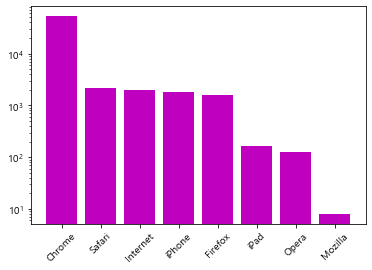

In [10]:
browserLabel = login3['browser'].str.split(" ").str[0]
plt.bar(browserLabel.value_counts().index, browserLabel.value_counts(), color='m' , log=True )
plt.xticks(rotation=45) 
plt.show()

#### 사람들의 접속사 추이는 어떨까?

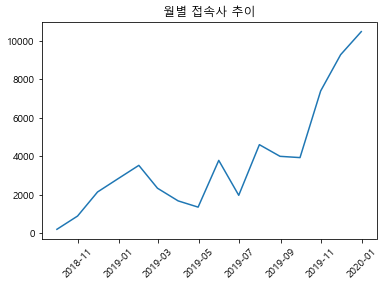

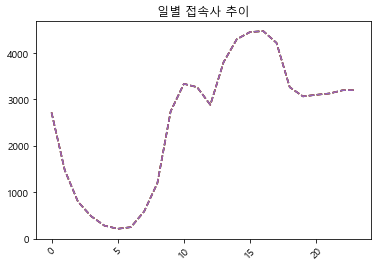

In [11]:
login3.index = pd.to_datetime(login3['c_time'])
plt.plot(login3['c_time'].resample('m').count(), '-')
plt.xticks(rotation=45)
plt.title('월별 접속사 추이')
plt.show()

login3['c_time'].resample('H').count()
login3['hour'] = login3.index.hour
plt.plot( np.linspace(0,23,24), login3.groupby('hour').count() , '--')
plt.xticks(rotation=45 )
plt.title('일별 접속사 추이')
plt.show()

### Step2. Arima model을 이용한 분석

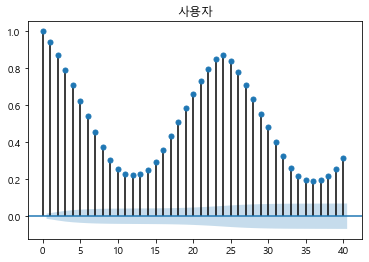

Adf : -5.689 P-value : 0.0
---------------------------------------------------------------------------


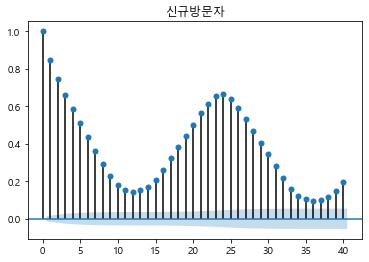

Adf : -8.377 P-value : 0.0
---------------------------------------------------------------------------


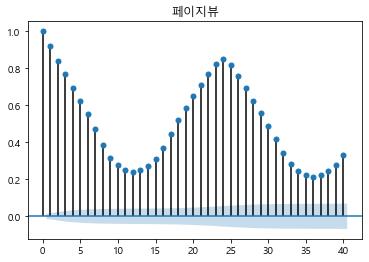

Adf : -5.622 P-value : 0.0


In [12]:
train = pd.concat([ data1, data2 ], axis=0)
plot_acf(train['사용자'],lags=40 )
plt.title('사용자')
plt.show()

# adfuller로 non-stationary 여부 확인
res = adfuller(train['사용자'])
print( 'Adf :', round(res[0],3), 'P-value :', round(res[1],3) )
print('-'*75)


plot_acf(train['신규방문자'],lags=40 )
plt.title('신규방문자')
plt.show()

res = adfuller(train['신규방문자'])
print( 'Adf :', round(res[0],3), 'P-value :', round(res[1],3) )
print('-'*75)


plot_acf(train['페이지뷰'],lags=40 )
plt.title('페이지뷰')
plt.show()

res = adfuller(train['페이지뷰'])
print( 'Adf :', round(res[0],3), 'P-value :', round(res[1],3) )

In [13]:
# # 돌아가는데 오래걸려서 생략.
# def arima_aic_check(data, order,sort = 'AIC'):
#     order_list = []
#     aic_list = []
#     bic_lsit = []
#     for p in range(order[0]):
#         for d in range(order[1]):
#             for q in range(order[2]):
#                 model = ARIMA(data, order=(p,d,q))
#                 try:
#                     model_fit = model.fit()
#                     c_order = f'p:{p} d:{d} q:{q}'
#                     aic = model_fit.aic
#                     bic = model_fit.bic
#                     order_list.append(c_order)
#                     aic_list.append(aic)
#                     bic_list.append(bic)
#                 except:
#                     pass
#     result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
#     result_df.sort_values(sort, inplace=True)
#     return result_df
# arima_aic_check(train['사용자'], [3,3,3]) # p:2 d:1 q:2 (User)
# arima_aic_check(train['신규방문자'], [3,3,3]) # p:2 d:1 q:2 (User)
# arima_aic_check(train['페이지뷰'], [3,3,3]) # p:2 d:1 q:2 (User)

In [14]:
# (1) 사용자수 
order = (2,1,2)
model_arima = ARIMA(train['사용자'], order)
arima_fit_user = model_arima.fit()
# arima_fit_user.summary()

# (2) 신규방문자 
order = (2,1,2)
model_arima = ARIMA(train['신규방문자'], order)
arima_fit_new_visitor = model_arima.fit()
# arima_fit_new_visitor.summary()

# (3) 페이지 뷰
order = (2,1,2)
model_arima = ARIMA(train['페이지뷰'], order)
arima_fit_view = model_arima.fit()

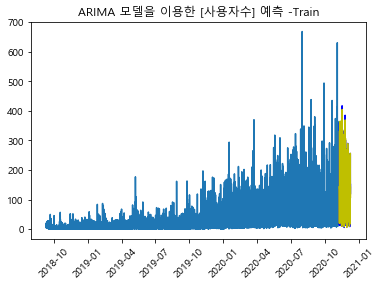

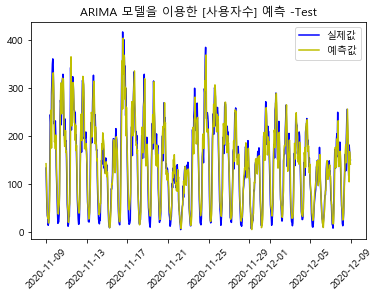

In [15]:
training = train[:'2020-11-09']['사용자'] 
testing  =  train['2020-11-09':]['사용자']
pred_user = arima_fit_user.predict( '2020-11-09', '2020-12-08', typ='levels' )

plt.plot( training  )
plt.plot( testing, 'b-' )
plt.plot( pred_user, 'y-' )
plt.title('ARIMA 모델을 이용한 [사용자수] 예측 -Train')
plt.xticks(rotation=45) 
plt.show()

plt.plot( testing, 'b-' )
plt.plot( pred_user, 'y-' )
plt.title('ARIMA 모델을 이용한 [사용자수] 예측 -Test')
plt.xticks(rotation=45) 
plt.legend(['실제값','예측값'])
plt.show()

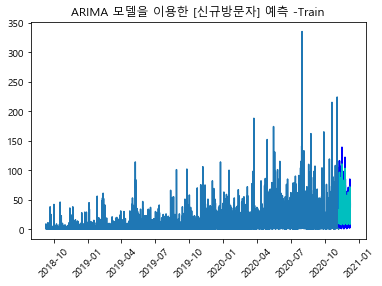

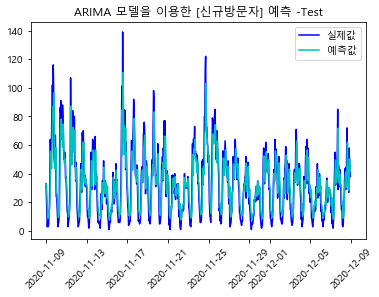

In [16]:
pred_new_visitor = arima_fit_new_visitor.predict( '2020-11-09', '2020-12-08', typ='levels' )
training = train[:'2020-11-09']['신규방문자'] 
testing  =  train['2020-11-09':]['신규방문자']

plt.plot( training  )
plt.plot( testing, 'b-' )
plt.plot( pred_new_visitor, 'c-' )
plt.title('ARIMA 모델을 이용한 [신규방문자] 예측 -Train')
plt.xticks(rotation=45) 
plt.show()

plt.plot( testing, 'b-' )
plt.plot( pred_new_visitor, 'c-' )
plt.title('ARIMA 모델을 이용한 [신규방문자] 예측 -Test')
plt.legend(['실제값','예측값'])
plt.xticks(rotation=45) 
plt.show()

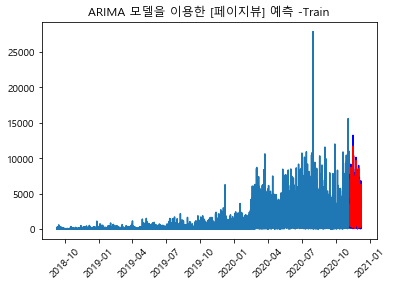

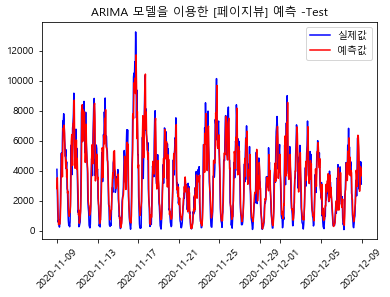

In [17]:
pred_view = arima_fit_view.predict( '2020-11-09', '2020-12-08', typ='levels' )
training = train[:'2020-11-09']['페이지뷰'] 
testing  =  train['2020-11-09':]['페이지뷰']

plt.plot( training  )
plt.plot( testing, 'b-' )
plt.plot( pred_view, 'r-' )
plt.title('ARIMA 모델을 이용한 [페이지뷰] 예측 -Train')
plt.xticks(rotation=45) 
plt.show()

plt.plot( testing, 'b-' )
plt.plot( pred_view, 'r-' )
plt.title('ARIMA 모델을 이용한 [페이지뷰] 예측 -Test')
plt.xticks(rotation=45) 
plt.legend(['실제값','예측값'])
plt.show()

### Machine Learinig을 이용한 학습 예측

### Step3. 시계열 데이터 정상성(Staitionary)

#### 문제 : 본 데이터는 정상시계열이 아닐 가능성이 높음.

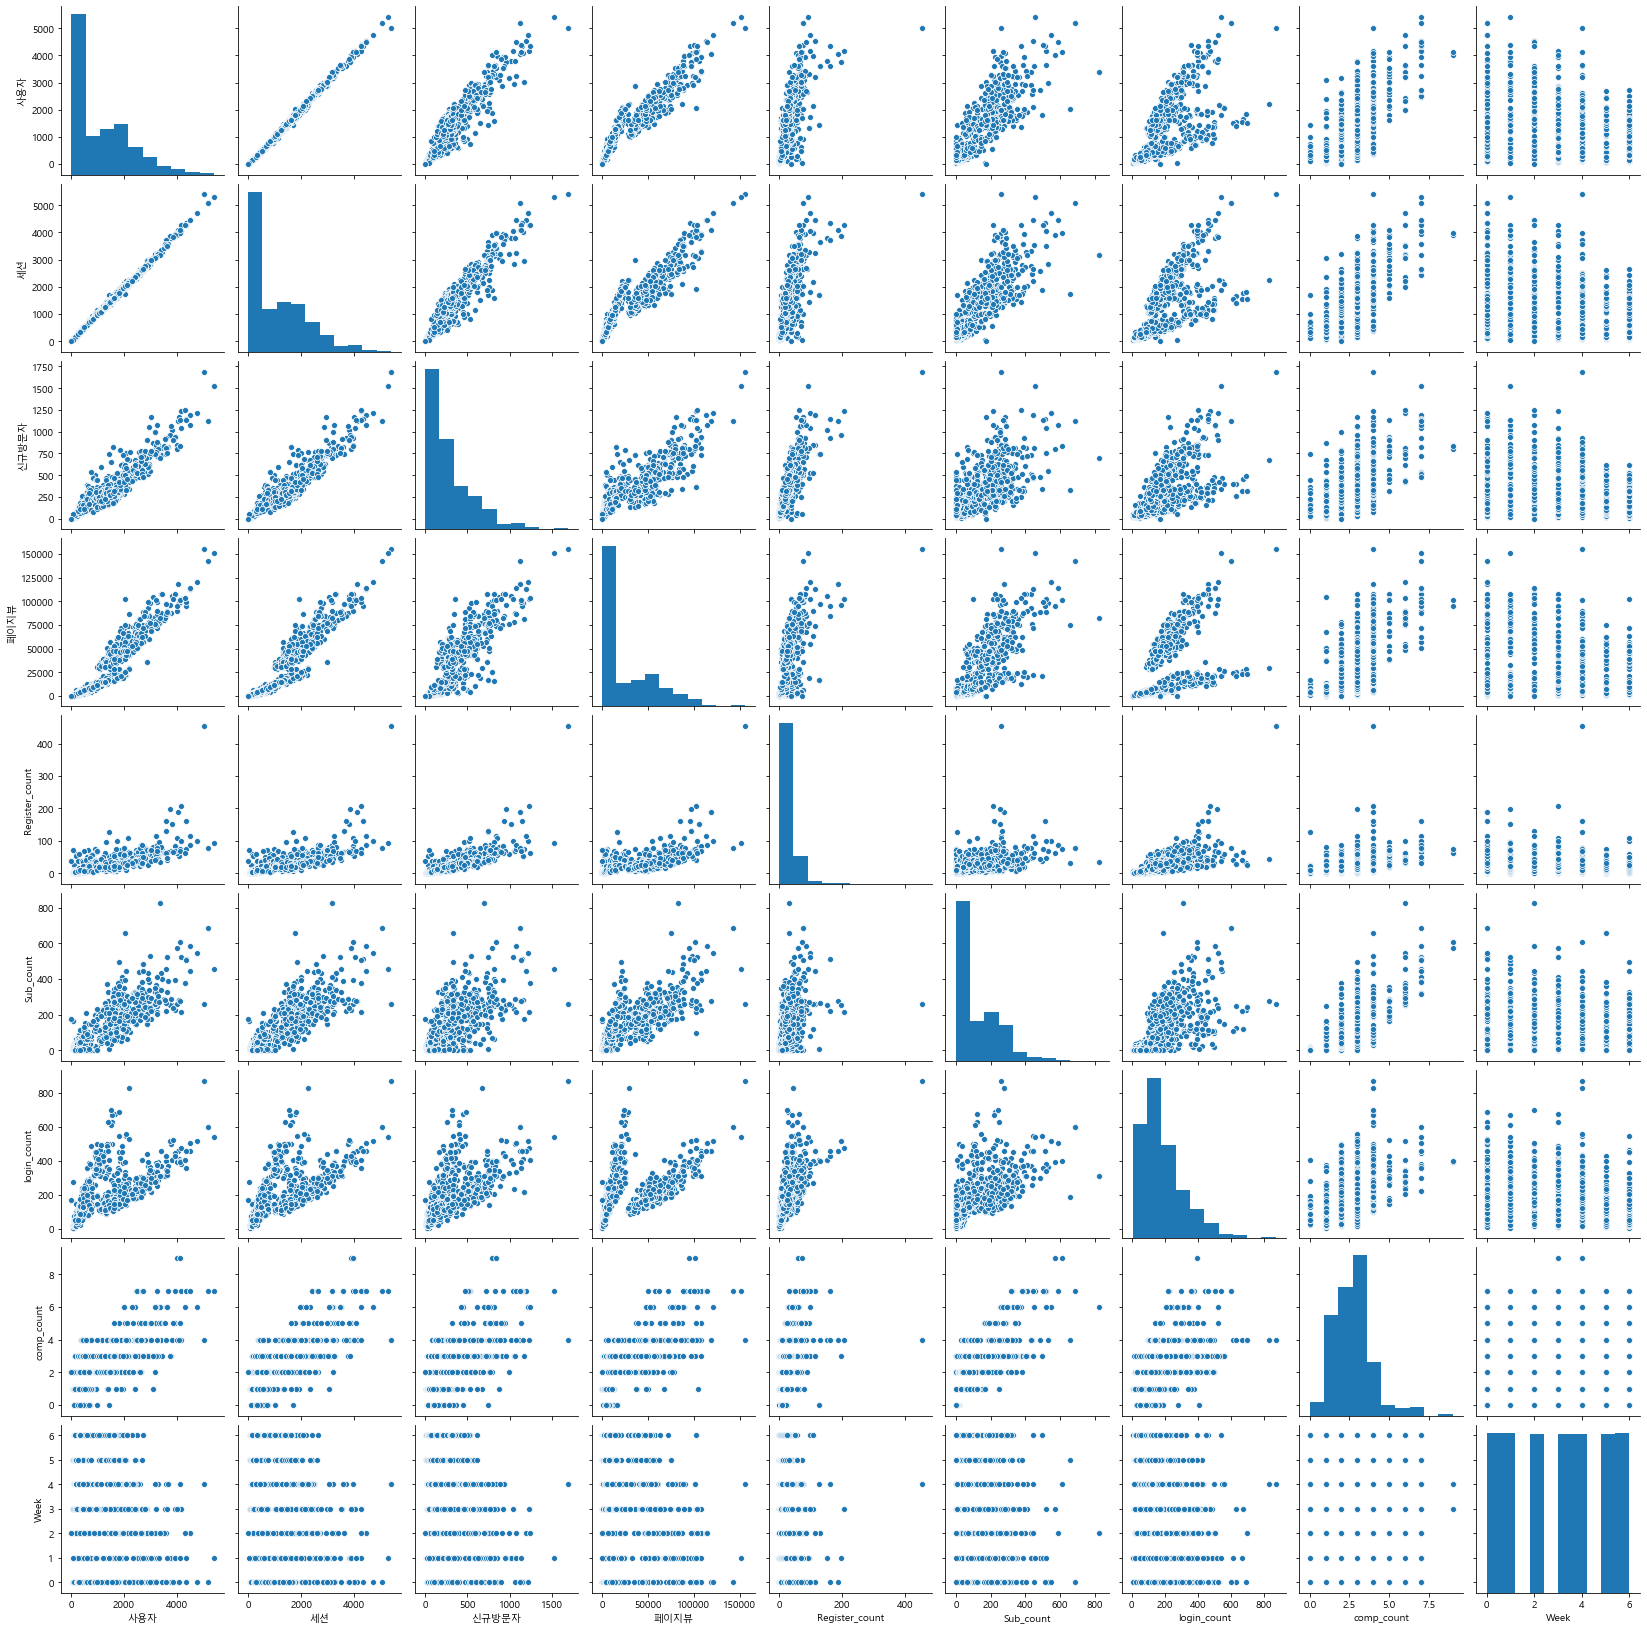

In [18]:
sb.pairplot(Train) ; plt.show()

#### 1차 차분 적용 ==> 2차분시 plot이 잘 안나와서 제외.

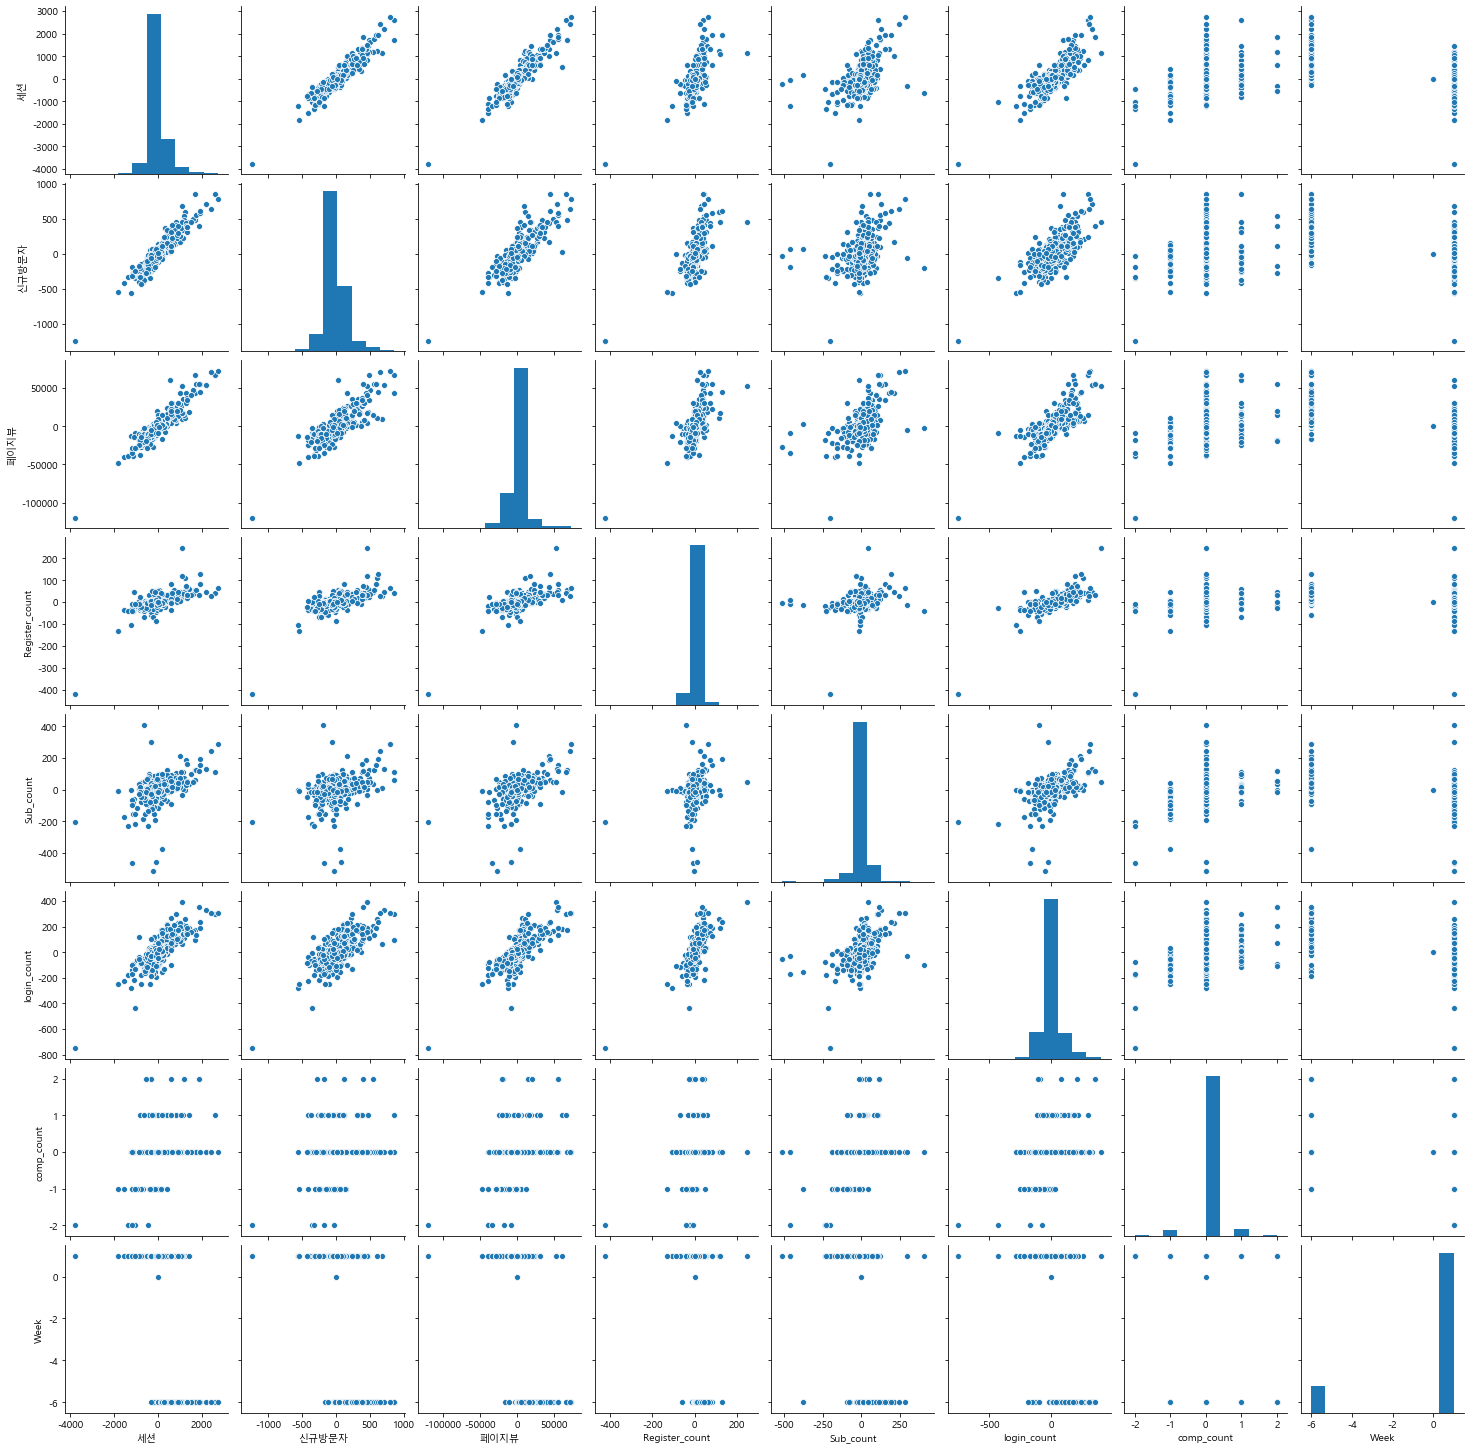

In [19]:
# 1차 차분 적용
x_data  = Train.drop( columns=['사용자','DateTime'] )
x_dataList = list(x_data.columns)

x_data_Diff1 = x_data

for i in x_dataList:
    x_data_Diff1[i] = x_data[i].diff()
    
x_data_Diff1 = x_data_Diff1.fillna(0)

df = pd.DataFrame(x_data_Diff1)
sb.pairplot(df)
plt.show()

#### log 변환 적용 

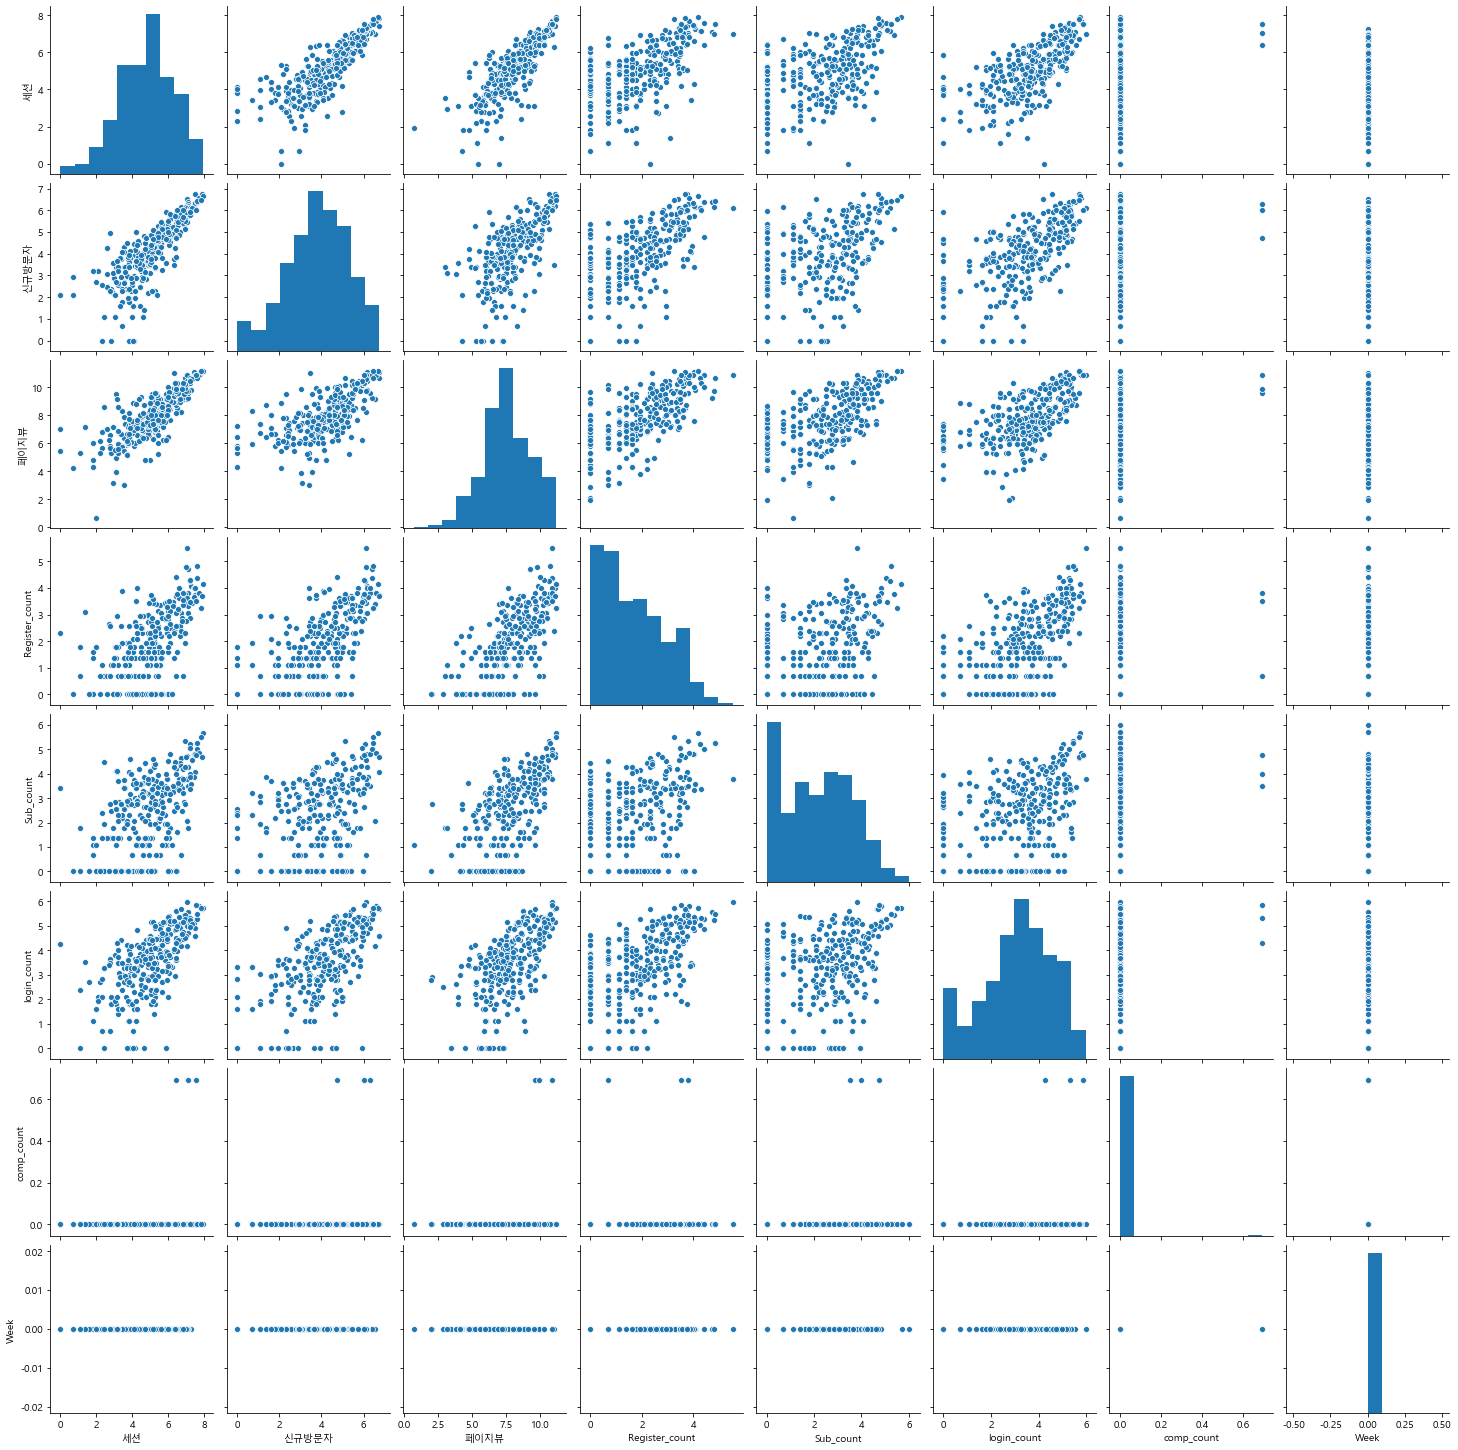

In [20]:
x_data_log = x_data

for i in x_dataList:
    for ii in np.arange(1,822):
        if x_data_log[i][ii] == 0:
            pass
        else:
            x_data_log[i][ii] = np.log(x_data_log[i][ii])
    
df = pd.DataFrame(x_data_log)
sb.pairplot(df)
plt.show()

#### 해결(Solution) ==> Box-cox Transformation

In [21]:
# 문제는 특성데이터의 정규성이 전혀 만족되보이지 않음. 즉 현재로서는 이 데이터는 비정상 시계열일 가능성이 높음. 
# => Box-cox 변환이나 log 변환, 차분 등의 다른 방식이 필요해 보임. 

y_data  = Train['사용자']
X_data  = Train.drop( columns=['사용자','DateTime'] )    
x_data  = StandardScaler().fit_transform( X_data )    # 시계열 데이터를 정규화 시킬 필요가 있음.

# x_dataList = list(x_data.columns)
# x_data_boxcox = x_data

# # Box-cox transformaion
# for i in x_dataList:
#     for ii in np.arange(0, 822):
#         if x_data_boxcox[i][ii] == 0:
#             x_data_boxcox[i][ii] = 1
    
#     x_trans, _ = stats.boxcox(x_data_boxcox[i])
#     x_data_boxcox[i] = x_trans

# # Min-max로 값을 표준화 해줌.
# x_data  = MinMaxScaler().fit_transform( x_data_boxcox )   


n       = round(len(Train)*0.9)
x_train = x_data[:n]
y_train = y_data[:n]

x_test  = x_data[n:]
y_test  = y_data[n:]

print(f'x_train shape : { x_train.shape } ')
print(f'y_train shape : { x_train.shape } ')
print(f'x_test shape  : { x_test.shape } ')
print(f'y_test shape  : { x_test.shape } ')

x_train shape : (740, 8) 
y_train shape : (740, 8) 
x_test shape  : (82, 8) 
y_test shape  : (82, 8) 


#### Pairplot of train data by Box-cox Transformation

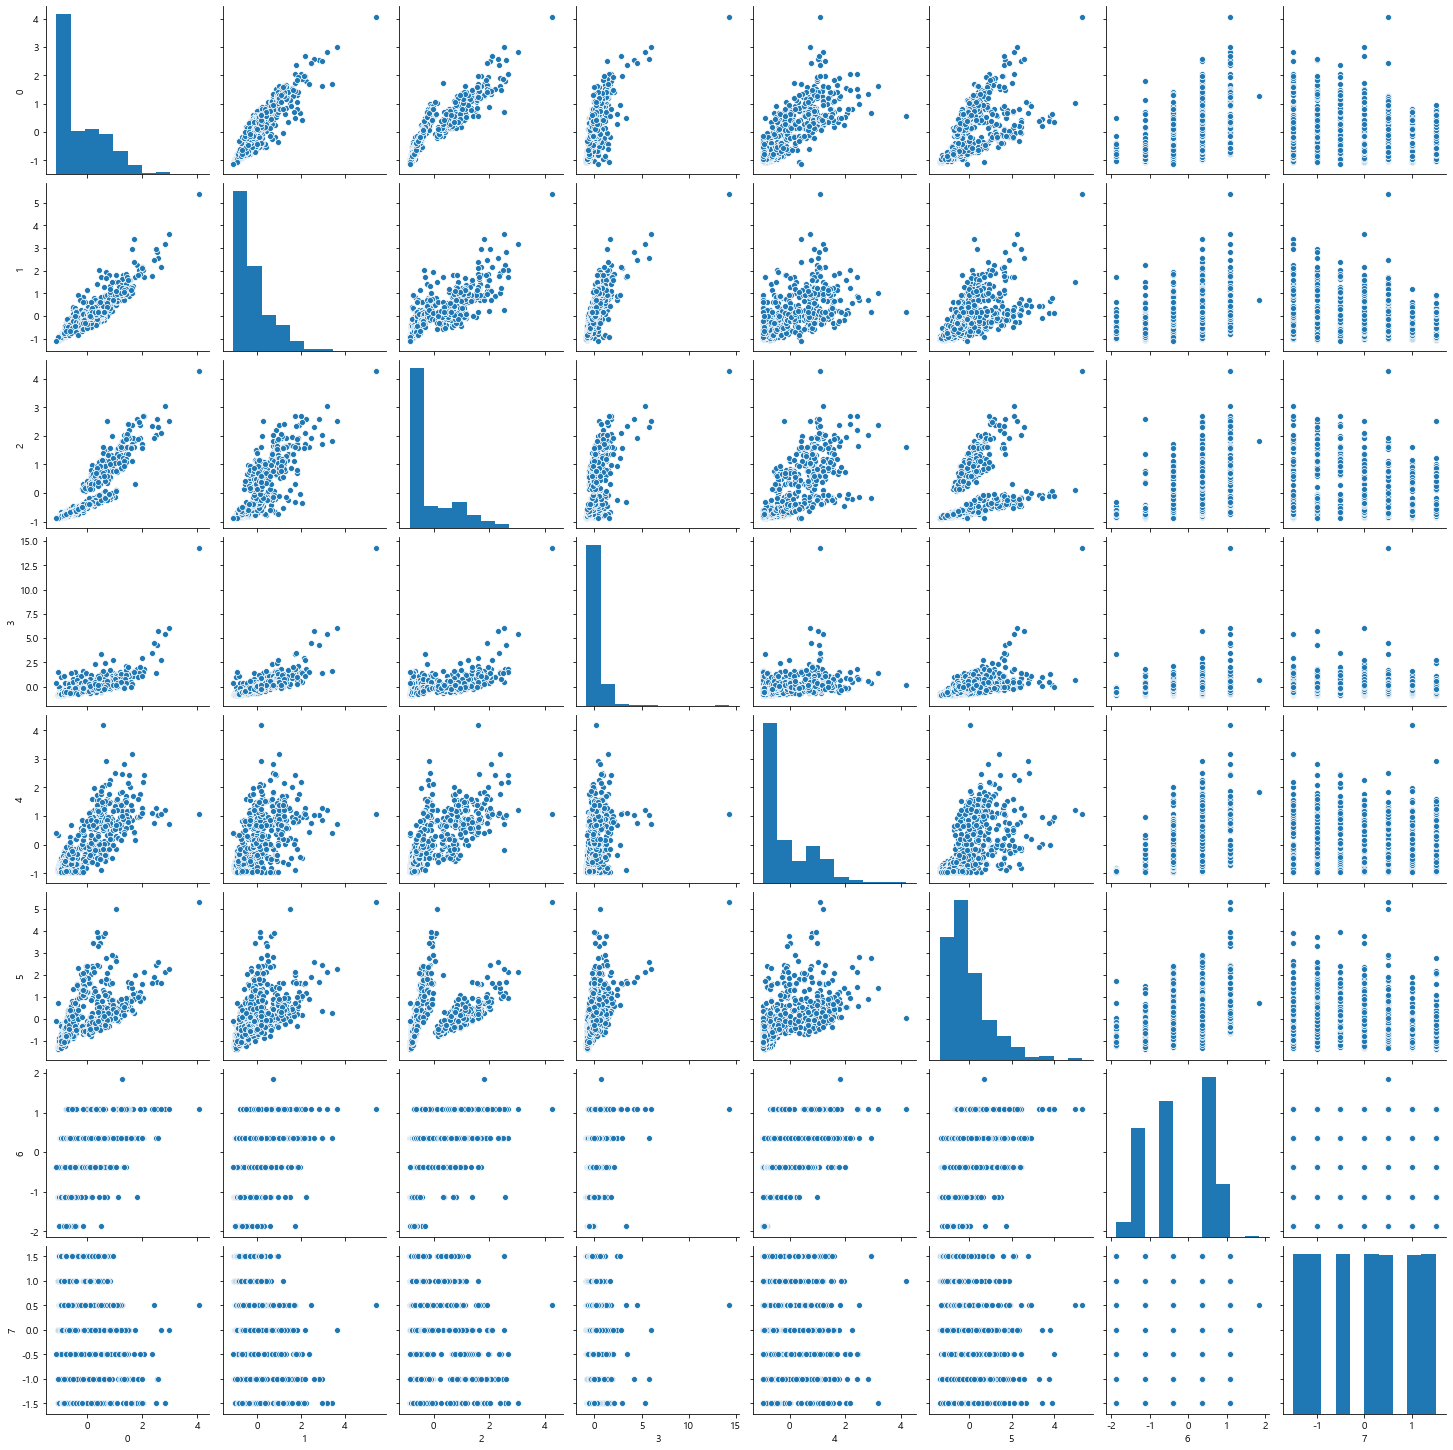

In [22]:
sb.pairplot(pd.DataFrame(x_train)) ; plt.show()

#### Pairplot of test data set  by Box-cox Transformation

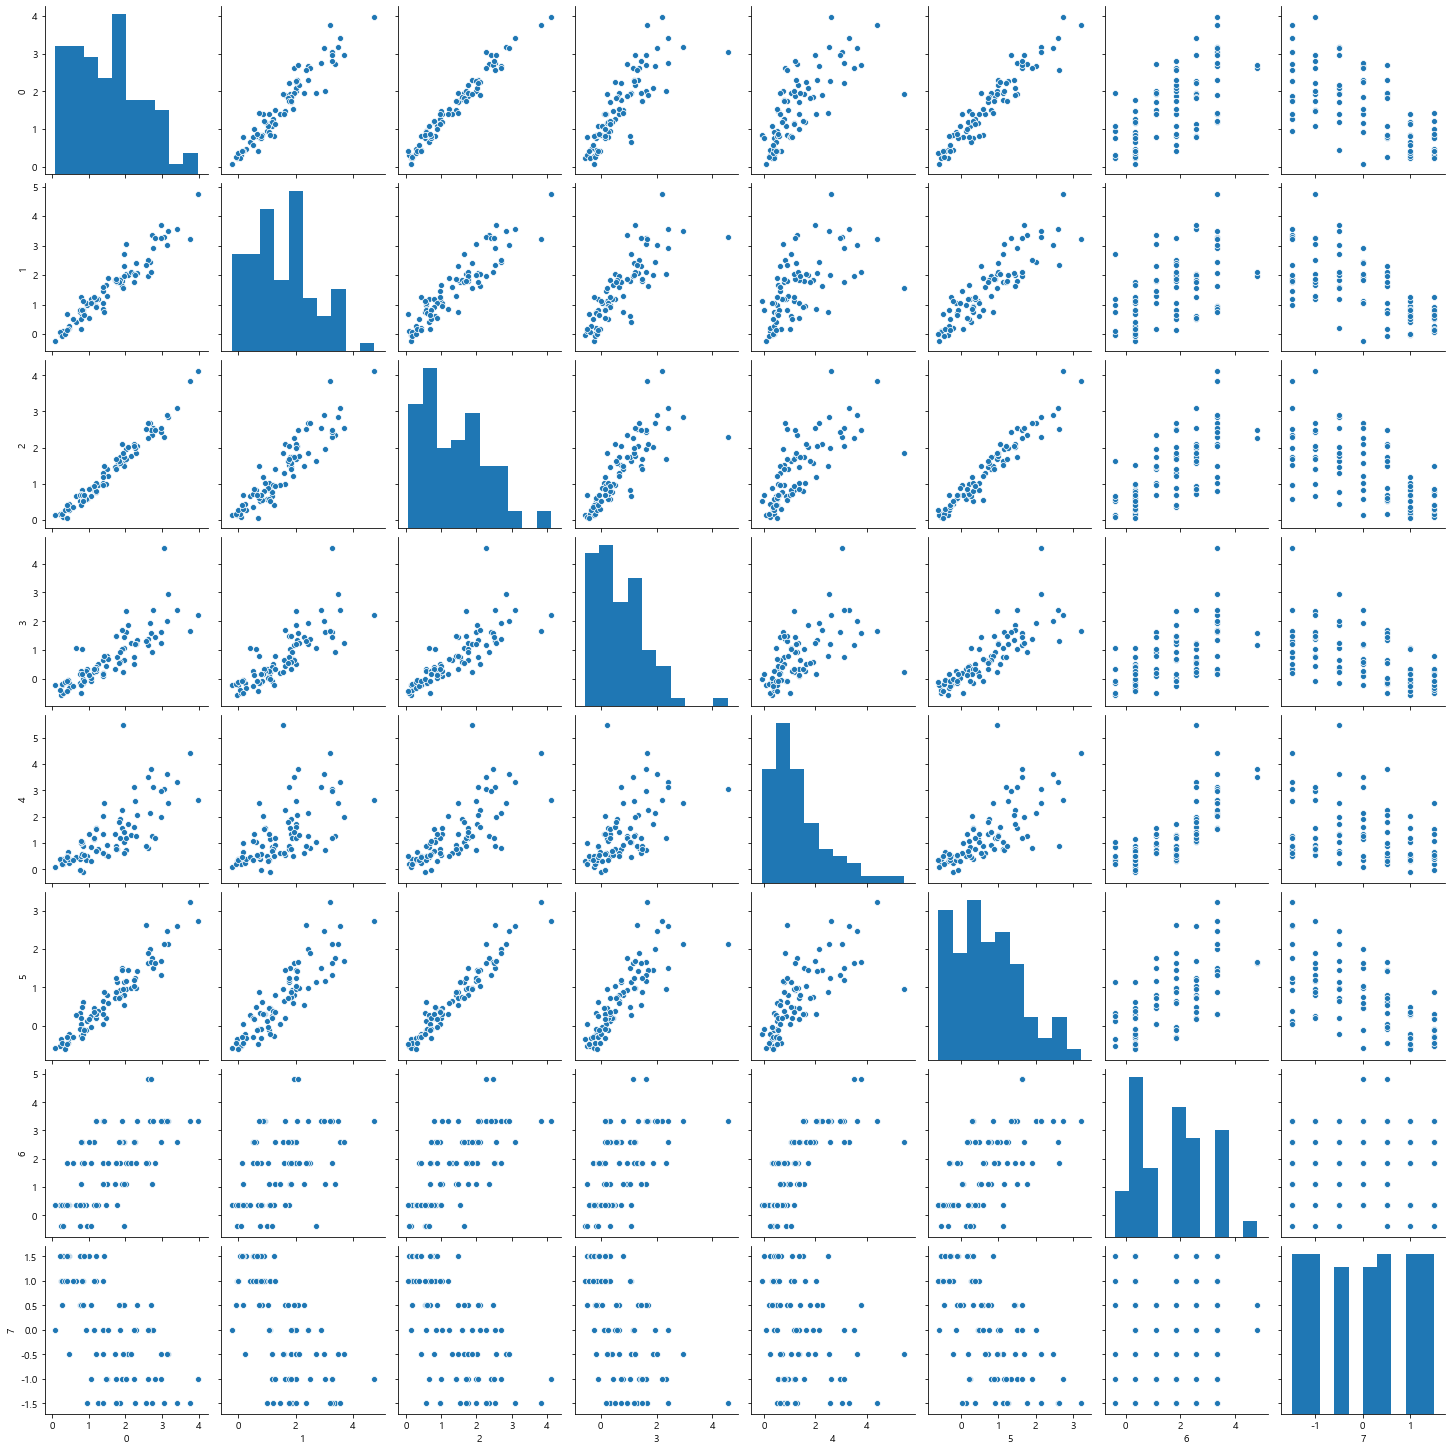

In [23]:
sb.pairplot(pd.DataFrame(x_test)) ; plt.show()

### Step4. 특성데이터 간의 상관관계와 다중공선성

#### Hitmap을 통한 상관관계 살펴보기.

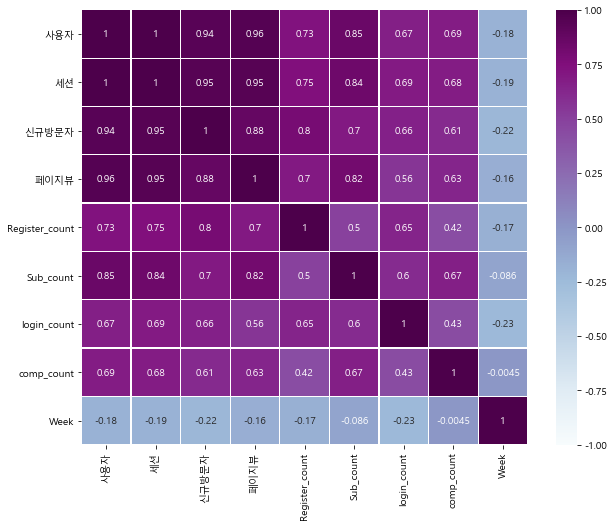

In [24]:
plt.figure(figsize=(10,8))
sb.heatmap(Train.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='BuPu' ) ; plt.show()

#### Target과의 유의미성 정도도 확인해보기.

In [25]:

print('< Criterion >')
print('-'*28)
print( f' AIC   : {round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().aic, 3)}' )
print( f' adjR2 : {round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().rsquared_adj, 3)}' )
print('-'*28)
print('< P-value >')
print('-'*28)
print( round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().pvalues[1:], 3) )

< Criterion >
----------------------------
 AIC   : 7486.489
 adjR2 : 1.0
----------------------------
< P-value >
----------------------------
x1    0.000
x2    0.515
x3    0.000
x4    0.000
x5    0.000
x6    0.000
x7    0.011
x8    0.004
dtype: float64


#### 다중공선성 파악하기.

In [26]:
# 상관관계와 ViF 값이 너무 높은 세션 Feature만 제거토록 한다. 그 외에는 학습할 데이터 자료가 현격히 줄어들어 나머지는 높은에도
# 따로 제거하지 않음.
VIF             = pd.DataFrame()
VIF['VIF']      = [ variance_inflation_factor( x_data, i ) for i in range( x_data.shape[1] ) ]
VIF['features'] = x_dataList
VIF

VIF        features
0  51.965792              세션
1  18.066666           신규방문자
2  14.130926            페이지뷰
3   3.309498  Register_count
4   5.778755       Sub_count
5   2.848040     login_count
6   2.062518      comp_count
7   1.112585            Week

#### 학습할 최종 데이터 구축 완료.

In [27]:
x_train = pd.DataFrame(x_train).iloc[:,1:]
x_test  = pd.DataFrame(x_test).iloc[:,1:]

### Step5. Machine Learinig을 이용한 Modeling

In [28]:
# GridSearch 

kf = KFold(n_splits=5)

Classifiers    = []
Parameters     = []

SGDR           = SGDRegressor(early_stopping=True)
lasso          = Lasso()
elastic        = ElasticNet()
MLP            = MLPRegressor(early_stopping=True)
RF             = RandomForestRegressor(oob_score=True )
KNN            = KNeighborsRegressor()


Parameters_SGDR  = { 'alpha': [0.001, 0.01, 0.1] 
                  }

Parameters_lasso = {'alpha': [0.0001,0.001, 0.01, 0.1, 1, 2 ] }


Parameters_Elas  = {'alpha': [0.0001, 0.01, 0.1, 1, 2 ],
                   'l1_ratio':[0.1,0.3,0.5,0.7,0.8]}


Parameters_MLP   = {'max_iter': [2000, 5000], 
                  'hidden_layer_sizes':[(100,2), (10,2) ], 
                  'learning_rate' : ['constant','adaptive'],
                 }

Parameters_RF    = {"max_features": [2,3,4],
                 "n_estimators" :[100,200,300]
                 }


Parameters_KNN   = {"n_neighbors": [3,5,7,9],
                  "weights": ['uniform','distance'],
                   "p":[1,2,3]
                 }

Classifiers.append( SGDR )
Classifiers.append( lasso )
Classifiers.append( elastic )
Classifiers.append( MLP )
Classifiers.append( RF  )
Classifiers.append( KNN )


Parameters.append( Parameters_SGDR )
Parameters.append( Parameters_lasso )
Parameters.append( Parameters_Elas )
Parameters.append( Parameters_MLP )
Parameters.append( Parameters_RF  )
Parameters.append( Parameters_KNN )


def gridSearchCV( models, params, count):
    best_models=[]
    for i in tqdm(range( 0, count )):
        model_grid = GridSearchCV( models[i], Parameters[i], cv=kf )
        model_grid.fit( x_train, y_train )
        best_models.append( model_grid.best_estimator_ )
    return best_models

best_model_list = gridSearchCV( Classifiers, Parameters, len(Classifiers) )

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:02<00:00, 10.48s/it]


In [29]:
# Accuracy of SGDR model.
print('- Accuracy of SGDR model -')
print('-'*138)
print(f'Best Parameter                 : { best_model_list[0].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[0].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[0].score( x_test, y_test ),   2)*100 }%')
print('-'*138)

 # -------------------------------------------------------------------------------------------------------------------------

# Accuracy of Lasso model.
print('- Accuracy of Lasso model -')
print('-'*138)
print(f'Best Parameter                 : { best_model_list[1].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[1].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[1].score( x_test, y_test ),   2)*100 }%')
print('-'*138)


 # -------------------------------------------------------------------------------------------------------------------------

# Accuracy of Elastic model.
print('- Accuracy of Elastic model -')
print('-'*138)
print(f'Best Parameter                 : { best_model_list[2].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[2].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[2].score( x_test, y_test ),   2)*100 }%')
print('-'*138)


# -------------------------------------------------------------------------------------------------------------------------

# Accuracy of MLP model.
print('- Accuracy of MLP model -')
print('-'*138)
print(f'Best Parameter                 : { best_model_list[3].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[3].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[3].score( x_test, y_test ),   2)*100 }%')
print('-'*138)

# Prediction of  MLP model.
# y_pred_train0  = best_model_list[0].predict( x_train )
# y_pred_test0   = best_model_list[0].predict( x_test )


# -------------------------------------------------------------------------------------------------------------------------

# Accuracy of RF model.
print('- Accuracy of RF model -')
print('-'*138)
print(f'Best Parameter                 : { best_model_list[4].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[4].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[4].score( x_test, y_test ),   2)*100 }%')
print('-'*138)

# Prediction of RF model.
# y_pred_train0  = best_model_list[1].predict( x_train )
# y_pred_test0   = best_model_list[1].predict( x_test )


# -------------------------------------------------------------------------------------------------------------------------

# Accuracy of KNN model.
print('- Accuracy of KNN model -')
print('-'*138)
print(f'Best Parameter                 : { best_model_list[5].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[5].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[5].score( x_test, y_test ),   2)*100 }%')
print('-'*138)

- Accuracy of SGDR model -
------------------------------------------------------------------------------------------------------------------------------------------
Best Parameter                 : <bound method BaseEstimator.get_params of SGDRegressor(alpha=0.01, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)>
Accuracy of train data         : 97.0%
Accuracy of test data          : 94.0%
------------------------------------------------------------------------------------------------------------------------------------------
- Accuracy of Lasso model -
----------------------------------------------------------------------------------------------------------------------

#### Lasso를 이용한 예측선

In [30]:
ypred = best_model_list[1].predict(x_test)
aa = pd.DataFrame(y_test)
df = Train[['DateTime']][n:]
aa['date'] = df['DateTime']
bb = pd.DataFrame( ypred )
bb['date'] = aa['date'].values
bb.columns = ['사용자', 'date']

fig = go.Figure()
fig.add_trace(go.Scatter(x=aa['date'],y=aa['사용자'],
             mode='lines+markers', name='actual'))
fig.add_trace(go.Scatter(x=bb['date'],y=bb['사용자'],
             mode='lines+markers', name='predict'))

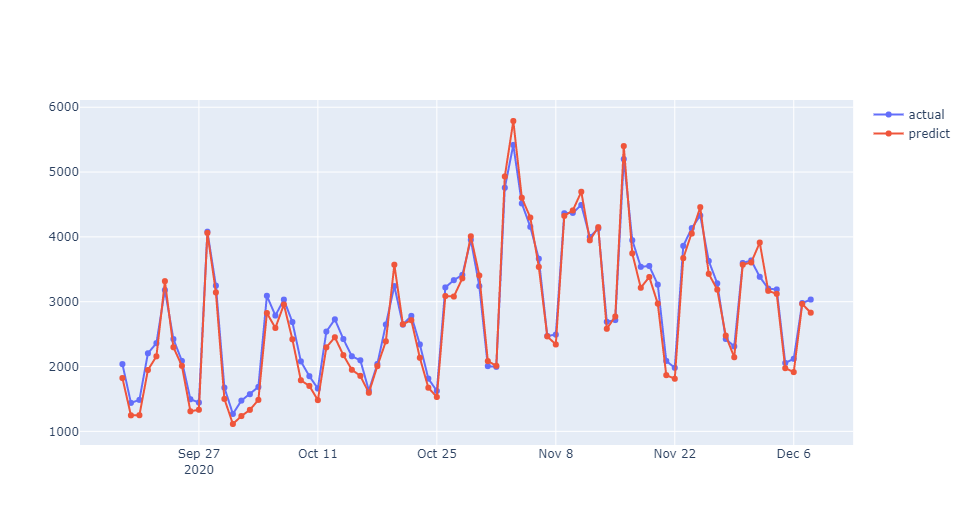

In [31]:
Image('image1/newplot.png')

### Reference :  fbprophet model을 이용한 분석.

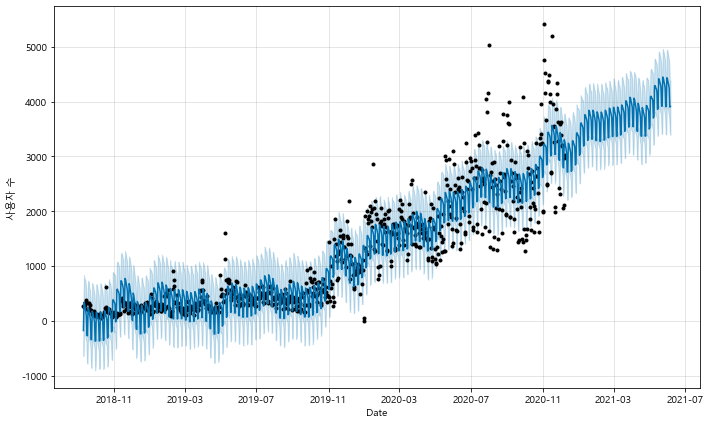

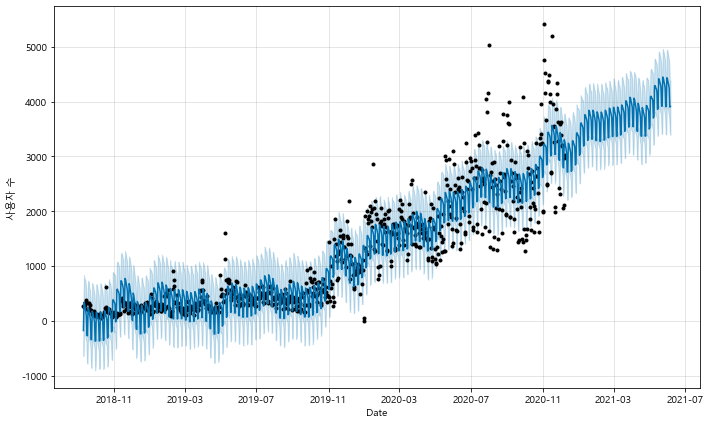

In [32]:
# fbprophet (페이스북에서 만든 모델)
train = pd.concat([ data1, data2 ])
Train = train.resample('1D').sum()
Train['date'] = Train.index
Train.reset_index(drop = True, inplace=True)
fb_Train = Train[['사용자','date']]

# fbprophet을 이용한 model 설정.
fb_Train.rename( columns={'date': 'ds', '사용자': 'y'},inplace=True )
model = Prophet(daily_seasonality=True) 
model.fit(fb_Train)

# 약 6개월 정도의 값을 데이터 프레임으로 반환.
forecast = model.make_future_dataframe(periods=180)  
predict  = model.predict(forecast)

# 약 6개월 정도의 예측선을 가진 plot 생성.
# 검은 점은 각 날의 사용자 수를 나타내며, 파란 선은 그 추세를 보여주고 있으며, 불투명구간은 오차범위를 보여줌.
model.plot(predict, xlabel = 'Date', ylabel = '사용자 수')